<a href="https://colab.research.google.com/github/dtabuena/Workshop/blob/main/Image/Test_Golgi_Quant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install opencv-python

In [4]:
import os
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import cv2

In [140]:
def plot_point_data(x,y,z,image_stack,vmin=None,vmax=None,lw=.2,figsize=(3,2.7),cmap='gray',rad=None):
    # () = xyz

    if rad is not None:
        min_x = np.max([x-rad,0])
        max_x = np.min([x+rad,image_stack.shape[0]])
        min_y = np.max([y-rad,0])
        max_y = np.min([y+rad,image_stack.shape[1]])
        image_stack = image_stack[min_y:max_y,min_x:max_x,:]
        x=rad
        y=rad

    fig,ax=plt.subplots(2,2,width_ratios=[5, 1],height_ratios=(5,1),figsize=figsize,dpi=300)
    ax[1,1].axis('off')

    ax[0,0].imshow(image_stack[:,:,z],aspect='auto',vmin=vmin,vmax=vmax,cmap=cmap,zorder=-1)
    ax[0,0].axvline(x,color='m',linewidth=lw)
    ax[0,0].axhline(y,color='c',linewidth=lw)

    collapse_x = image_stack[y,:,:].T
    ax[1,0].imshow(collapse_x,aspect='auto',vmin=vmin,vmax=vmax,cmap=cmap,zorder=-1)
    ax[1,0].axhline(z,color='y',linewidth=lw)
    ax[1,0].axvline(x,color='m',linewidth=lw)

    collapse_y =image_stack[:,x,:]
    print(collapse_y.shape)
    ax[0,1].imshow(collapse_y,aspect='auto',vmin=vmin,vmax=vmax,cmap=cmap,zorder=-1)
    ax[0,1].axvline(z,color='y',linewidth=lw)
    ax[0,1].axhline(y,color='c',linewidth=lw)


    # if rad is not None:
        # min_x = np.max([x-rad,0])
        # max_x = np.min([x+rad,image_stack.shape[0]])
        # min_y = np.max([y-rad,0])
        # max_y = np.min([y+rad,image_stack.shape[1]])

        # print(min_x,max_x,min_y,max_y)

        # ax[0,0].set_xlim(min_x,max_x)
        # ax[0,0].set_ylim(min_y,max_y)

        # ax[1,0].set_xlim(min_x,max_x)
        # ax[0,1].set_ylim(min_y,max_y)
    return fig,ax


In [35]:
image_stack.shape

(1440, 1920, 172)

In [6]:
def stack_snake(img_arr,row_n,col_n=None):
    img_arr=np.array(img_arr)
    if col_n is None: col_n=row_n
    X = np.arange(row_n*col_n).reshape(row_n,col_n)
    for r in np.arange(1,row_n,2):
        X[r,:] = X[r,::-1]

    cat_rows = [np.concatenate(img_arr[X[r,:]],axis=1) for r  in range(row_n)]
    concat = np.concatenate(cat_rows,axis=0)
    return concat

def plot_img_grid( images , r,c=None):
    plt.imshow(stack_snake(images,row_n=r,col_n=c))

In [7]:
image_set_dir = "C:\\Users\\dennis.tabuena\\Dropbox (Gladstone)\\0_Projects\\_Hyper+Crisper\\Morphological_Analysis\\CA1\\"
image_tag = 'Overlay'

os.chdir(image_set_dir)

tif_list=list()
for dir,root,files in os.walk(image_set_dir):
    for f in files:
        if image_tag in f:
            tif_list.append(os.path.join(dir,f))

pd_dict = {'file_loc': [t for t in tif_list],
           'z': [t.split("_")[-2] for t in tif_list]}
image_df = pd.DataFrame(pd_dict)

display(image_df)


,file_loc,z
0,C:\Users\dennis.tabuena\Dropbox (Gladstone)\0_...,Z00001
1,C:\Users\dennis.tabuena\Dropbox (Gladstone)\0_...,Z00002
2,C:\Users\dennis.tabuena\Dropbox (Gladstone)\0_...,Z00003
3,C:\Users\dennis.tabuena\Dropbox (Gladstone)\0_...,Z00004
4,C:\Users\dennis.tabuena\Dropbox (Gladstone)\0_...,Z00005
...,...,...
167,C:\Users\dennis.tabuena\Dropbox (Gladstone)\0_...,Z00168
168,C:\Users\dennis.tabuena\Dropbox (Gladstone)\0_...,Z00169
169,C:\Users\dennis.tabuena\Dropbox (Gladstone)\0_...,Z00170
170,C:\Users\dennis.tabuena\Dropbox (Gladstone)\0_...,Z00171


In [27]:
"""Build Stack"""
image_stack = list()
for path in image_df['file_loc']:
    image_data =cv2.imread(path)
    # image_data = np.mean(image_data,axis=-1)
    image_data = image_data[:,:,1]
    image_stack.append(image_data)
image_stack=np.stack(image_stack,axis=-1)
print(image_stack.shape)


(1440, 1920, 172)


(1440, 172)
534 934 380 780


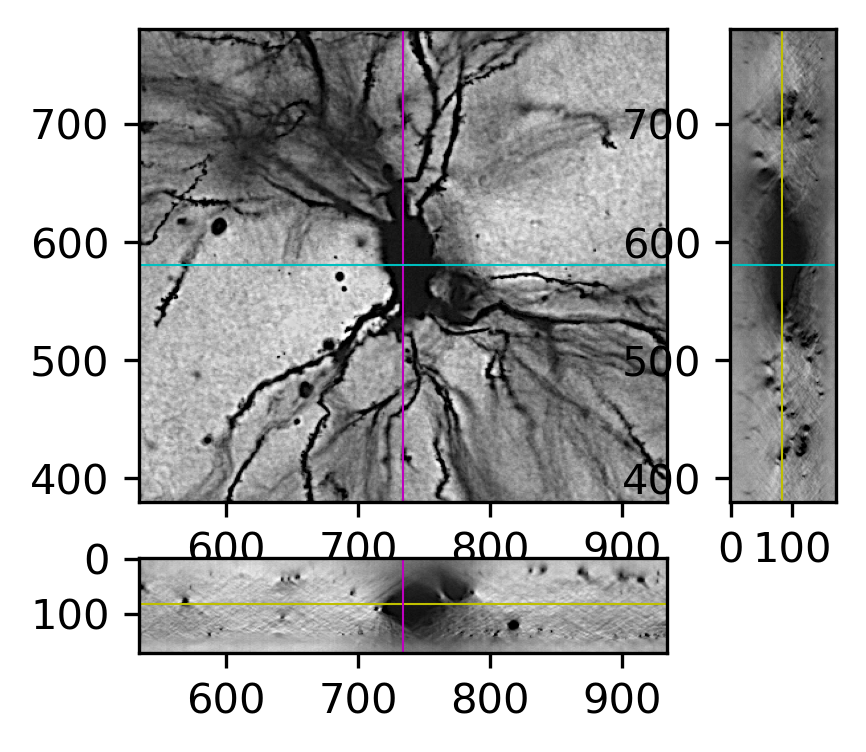

In [81]:
(x,y,z) = (734,565,83)
plot_point_data(x,y,z,image_stack,rad=200,lw=.5)

image_stack




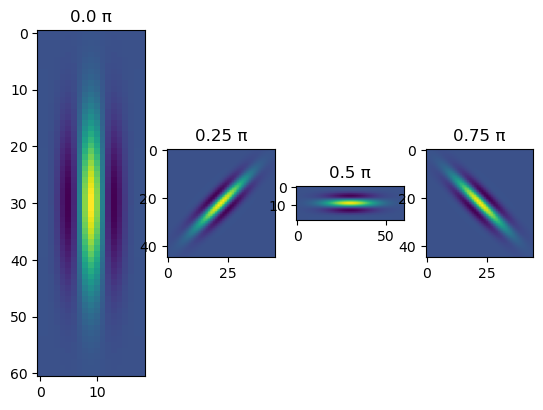

(400, 172)


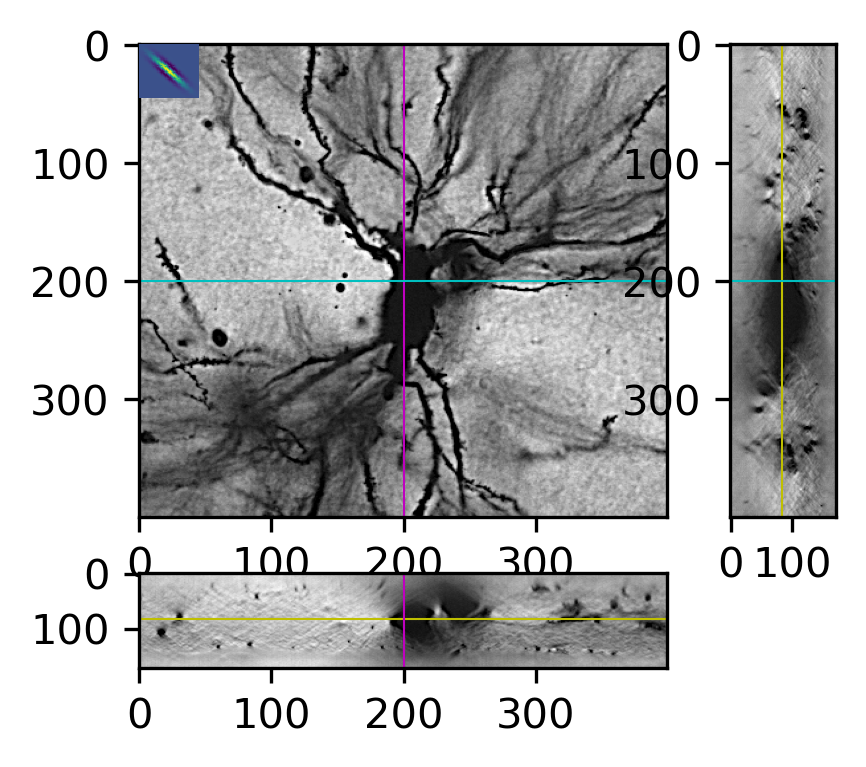

In [245]:
""" Define Filters """
# def base_filter_3d(len,rad):

import skimage as ski

gabor_set_def = {'rad': 3,
                 'len': 10,
                 'n_ker': 4,
                 'frequency': .1,
                 'sigma_x': rad,
                 'sigma_y': len,
                 'n_stds': 3,
                 }
gabor_set_def['thetas'] = np.arange(0,1,1/gabor_set_def['n_ker']) * np.pi

fig,ax=plt.subplots(1,gabor_set_def['n_ker'])
filter_set=list()
for a,theta in zip(ax,gabor_set_def['thetas']):
    filter = np.real(ski.filters.gabor_kernel(gabor_set_def['frequency'],
                                              theta,
                                              sigma_x=gabor_set_def['rad'],
                                              sigma_y=gabor_set_def['len'],
                                              n_stds=gabor_set_def['n_stds'],))
    filter_set.append(filter)
    a.imshow(filter)
    a.set_title(f"{theta/np.pi} π")

plt.show()
fig,ax = plot_point_data(x,y,z,image_stack,rad=200,lw=.5)
ax[0,0].pcolor(filter,zorder=99)


(1440, 172)
534 934 365 765


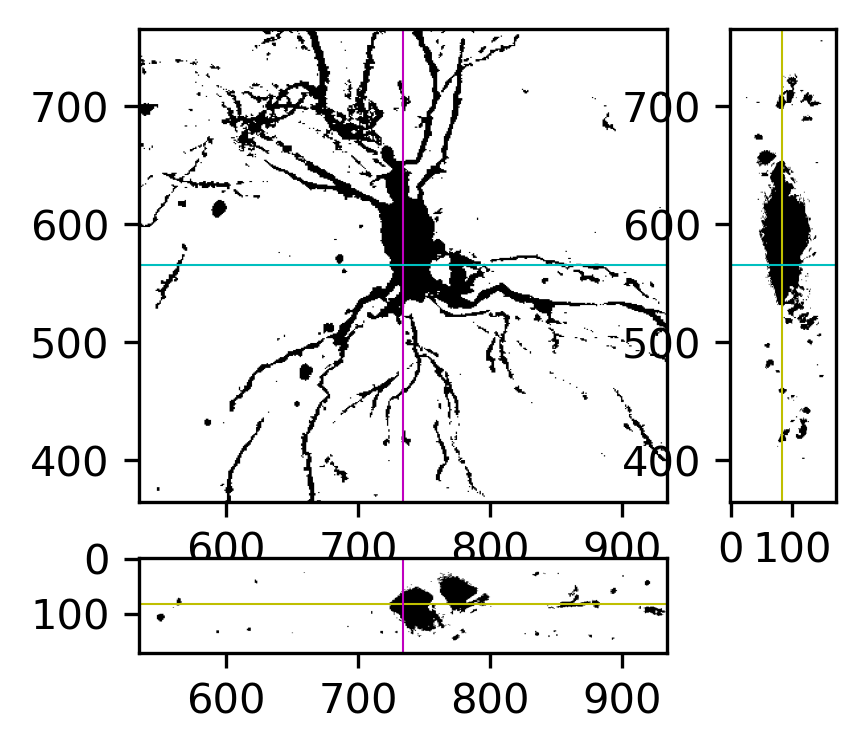

In [103]:
""" Threshold (PROBABLY DONT USE) """
def z_thresh(image_stack,z_thresh=-3):
    stack_norm = (image_stack - np.mean(image_stack) )/ np.std(image_stack)
    if z_thresh<0:
        mask=stack_norm<z_thresh
    elif z_thresh>0:
        mask=stack_norm>z_thresh
    return mask,stack_norm


mask,stack_norm = z_thresh(image_stack,z_thresh=-2)
plot_point_data(x,y,z,np.logical_not(mask),rad=200,lw=.5)

In [ ]:
""" Blur (Dont use) """
# import scipy as sp
image_stack_blur = sp.ndimage.gaussian_filter(image_stack,sigma=[.5,.5,0])
plot_point_data(x,y,z,image_stack_blur,rad=200,lw=.5)

0

In [ ]:
!pip install stitching
from stitching import Stitcher


In [ ]:
# z_planes = sorted(list(set(image_df['z'])))
# print(z_planes)

# for cur_z in [z_planes[15]]:
#     single_plane_images = image_df['file_loc'][[cur_z in z for z in image_df['z']]].values
# image_data_list = list()
# for path in single_plane_images:
#     image_data =cv2.imread(path)
#     image_data_list.append(image_data)
# order = np.array(list(range(0,5,1)) + list(range(9,4,-1)) + list(range(10,15,1)) + list(range(19,14,-1)) + list(range(20,25,1)))
# image_data_list_sorted = [image_data_list[o] for o in order]

# fig,ax=plt.subplots(5,5)
# ax = ax.flatten()
# for i,f in enumerate(image_data_list_sorted):
#     ax[i].imshow(f)


# subset = image_data_list

In [ ]:
# from stitching.images import Images
# paths = single_plane_images
# images = Images.of(paths)

In [ ]:
# def plus_mask(img,n=.35,rs=None):
#     if rs is None:
#         rs = img.shape[:2]
#     mask = np.ones_like(img[:,:,0])
#     m_shape = np.shape(mask)
#     mask[int(m_shape[0]*n):int(m_shape[0]*(1-n)),:] = 0
#     mask[:,int(m_shape[1]*n):int(m_shape[1]*(1-n))] = 0
#     # mask[int(m_shape[0]*n):int(m_shape[0]*(1-n)),int(m_shape[1]*n):int(m_shape[1]*(1-n))] = 0
#     mask = cv2.resize(mask, (rs[1],rs[0]))
#     return mask.astype(int)

# fig,ax=plt.subplots(1,figsize=(1,1))
# plt.imshow(plus_mask(img,n=.35))

In [ ]:
# [:-1]
# len(subset)
# single_plane_images = single_plane_images[:-1]
# len(subset)

In [ ]:
# from stitching.images import Images
# img = Images.of(subset, medium_megapix=0.96, low_megapix=0.1, final_megapix=-1)
# medium_imgs = list(img.resize(Images.Resolution.MEDIUM))
# subset = medium_imgs

# from stitching.feature_detector import FeatureDetector
# finder = FeatureDetector(detector='sift', nfeatures=500)

# features = [finder.detect_features(img, plus_mask(img,n=.35) ) for img in subset]

# from stitching.feature_matcher import FeatureMatcher
# matcher = FeatureMatcher()
# matches = matcher.match_features(features)
# matcher.get_confidence_matrix(matches)
# conf_mat = matcher.get_confidence_matrix(matches)

# fig,ax=plt.subplots(5,5,figsize=(8,8))
# ax = ax.flatten()
# for i,(img,feat) in enumerate(zip(subset,features)):
#     img_h = img.copy()
#     img_h[:,:,2] = plus_mask(img,n=.35)*255
#     ax[order[i]].imshow(img_h)
#     ax[order[i]].set_xticks([])
#     ax[order[i]].set_yticks([])
#     for k in feat.keypoints:
#         ax[order[i]].scatter(k.pt[0],k.pt[1],s=1,color='m')
#         ax[order[i]].set_title(i)


# conf_mat = matcher.get_confidence_matrix(matches)
# conf_mat[conf_mat==0]=np.nan
# fig,ax=plt.subplots(1,figsize=(5,5))
# cb=ax.imshow(conf_mat)
# plt.colorbar(cb)
# ax.grid('on')
# np.nanmin(conf_mat,1)

# from stitching.subsetter import Subsetter
# subsetter = Subsetter()
# dot_notation = subsetter.get_matches_graph([str(i) for i in range(25)], matches)
# print(dot_notation)



In [ ]:

# fig,ax=plt.subplots(5,5,figsize=(8,8))
# ax = ax.flatten()
# for i,img in enumerate(warped_final_imgs):
#     ax[order[i]].imshow(img)
#     ax[order[i]].set_xticks([])
#     ax[order[i]].set_yticks([])
#     ax[order[i]].set_title(i)

In [ ]:
# def plot_image(img, figsize_in_inches=(5,5)):
#     fig, ax = plt.subplots(figsize=figsize_in_inches)
#     ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
#     plt.show()

# def plot_images(imgs, figsize_in_inches=(5,5)):
#     fig, axs = plt.subplots(1, len(imgs), figsize=figsize_in_inches)
#     for col, img in enumerate(imgs):
#         axs[col].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
#     plt.show()

In [ ]:
########################################## AFFINE ####################################################

from stitching.images import Images
from stitching import AffineStitcher

def aff_stitch_og_size_X(my_images,img_paths,r,c=None,order=None):
    """ Stitch a single 2-d Plane """

    """ INIT Stitcher & Results """
    results = {}
    settings = { "confidence_threshold": 1.2}
    aff_stitcher = AffineStitcher(**settings)
    results['stitched'] = np.zeros([3,3,3],'uint8')

    """ Image Init """
    results['images'] = Images.of(list(img_paths))
    # results['medium_imgs'] = list(images.resize(Images.Resolution.FINAL))
    # results['low_imgs'] = list(images.resize(Images.Resolution.FINAL))
    results['final_imgs'] = list(results['images'].resize(Images.Resolution.FINAL))


    """ Feature Detection """
    results = feature_detect(aff_stitcher,my_images,results)


    """
    If poor Feature Detection just quit and move on
    (likely a blurry low contrast image)
    """
    if results['fewest_points']:
        results['message'] = 'not enough points'
        results['matches'] = np.nan
        results['cameras'] = np.nan
        return results


    """ Matching """
    results = match_feats(aff_stitcher,results)


    """ Fit The Transform  """
    results = solve_for_camera(aff_stitcher,results)


    """ Apply Transform """
    results = solve_for_camera(aff_stitcher,results)


    """ Cropping """
    'currelty bypassed'


    """ Do the 'Stitch' """
    results = stitch_scaled_images(aff_stitcher,reults)
    return results


In [ ]:
def aff_stitch_og_size(my_images,img_paths,r,c=None,order=None):
    results = {}
    results['stitched'] = np.zeros([3,3,3],'uint8')




    from stitching.images import Images
    from stitching import AffineStitcher


    images = Images.of(list(img_paths))
    medium_imgs = list(images.resize(Images.Resolution.FINAL))
    low_imgs = list(images.resize(Images.Resolution.FINAL))
    final_imgs = list(images.resize(Images.Resolution.FINAL))


    """ INIT Stitcher """
    settings = { "confidence_threshold": 1.2}
    aff_stitcher = AffineStitcher(**settings)


    """ Feature Detection """
    features = aff_stitcher.find_features(my_images)
    results['features']=features
    num_feats = [len(f.keypoints) for f in results['features']]
    fewest_points = np.min(num_feats)
    results['fewest_points']=fewest_points
    if fewest_points < 25:
        results['message'] = 'no enough points'
        results['matches'] = np.nan
        results['cameras'] = np.nan
        return results
    ##
    # fig,ax=plt.subplots(5,5,figsize=(3,3))
    # ax = ax.flatten()
    # for i,(img,feat) in enumerate(zip(my_images,features)):
    #     img_h = img.copy()
    #     # img_h[:,:,2] = plus_mask(img,n=.35)*255
    #     ax[order[i]].imshow(img_h)
    #     ax[order[i]].set_xticks([])
    #     ax[order[i]].set_yticks([])
    #     for k in feat.keypoints:
    #         ax[order[i]].scatter(k.pt[0],k.pt[1],s=1,color='m')
    #         ax[order[i]].set_title(i)
    # plt.show()

    """ Matching """
    matches = aff_stitcher.match_features(features)
    results['matches']=matches
    conf_mat = aff_stitcher.matcher.get_confidence_matrix(matches)
    conf_mat[conf_mat==0]=np.nan
    indicies = aff_stitcher.subsetter.get_indices_to_keep(features,matches)
    dot_notation = aff_stitcher.subsetter.get_matches_graph([str(i) for i in range(25)], matches)
    ##
    # fig,ax=plt.subplots(1,figsize=(5,5))
    # cb=ax.imshow(conf_mat,vmin=0.5)
    # plt.colorbar(cb)
    # ax.grid('on')
    # np.nanmax(conf_mat,1)

    """ Solve Warp """
    cameras = aff_stitcher.camera_estimator.estimate(features, matches)
    cameras = aff_stitcher.camera_adjuster.adjust(features, matches, cameras)
    cameras = aff_stitcher.wave_corrector.correct(cameras)
    aff_stitcher.warper.set_scale(cameras)
    results['cameras']=cameras

    final_sizes = images.get_scaled_img_sizes(Images.Resolution.FINAL)
    camera_aspect = images.get_ratio(Images.Resolution.FINAL, Images.Resolution.FINAL)

    warped_final_imgs = list(aff_stitcher.warper.warp_images(final_imgs, cameras, camera_aspect))
    warped_final_masks = list(aff_stitcher.warper.create_and_warp_masks(final_sizes, cameras, camera_aspect))
    final_corners, final_sizes = aff_stitcher.warper.warp_rois(final_sizes, cameras, camera_aspect)
    ##
    # fig,ax=plt.subplots(5,5,figsize=(8,8))
    # ax = ax.flatten()
    # for i,img in enumerate(warped_final_imgs):
    #     ax[order[i]].imshow(img)
    #     # ax[order[i]].set_xticks([])
    #     # ax[order[i]].set_yticks([])
    #     ax[order[i]].set_title(i)


    # """ Cropping """
    cropped_final_imgs = warped_final_imgs
    cropped_final_masks = warped_final_masks
    # , final_corners, final_sizes

    # cropper = aff_stitcher.cropper
    # mask = cropper.estimate_panorama_mask(warped_final_imgs, warped_final_masks, final_corners, final_sizes)
    # lir = cropper.estimate_largest_interior_rectangle(mask)


    # final_corners = cropper.get_zero_center_corners(final_corners)
    # rectangles = cropper.get_rectangles(final_corners, final_sizes)
    # overlap = cropper.get_overlap(rectangles[1], lir)
    # intersection = cropper.get_intersection(rectangles[1], overlap)

    # cropper.prepare(warped_final_imgs, warped_final_masks, final_corners, final_sizes)

    # lir_aspect = images.get_ratio(Images.Resolution.FINAL, Images.Resolution.FINAL)  # since lir was obtained on low imgs
    # cropped_final_masks = list(cropper.crop_images(warped_final_masks, lir_aspect))
    # cropped_final_imgs = list(cropper.crop_images(warped_final_imgs, lir_aspect))
    # final_corners, final_sizes = cropper.crop_rois(final_corners, final_sizes, lir_aspect)

    """ Seams """
    seam_finder = aff_stitcher.seam_finder
    seam_masks = seam_finder.find(cropped_final_imgs, final_corners, cropped_final_masks)
    seam_masks_plots = [seam_finder.draw_seam_mask(img, seam_mask) for img, seam_mask in zip(cropped_final_imgs, seam_masks)]

    """ Exposure Comp """
    compensator = aff_stitcher.compensator
    compensator.feed(final_corners, cropped_final_imgs, cropped_final_masks)
    compensated_imgs = [compensator.apply(idx, corner, img, mask)
                        for idx, (img, mask, corner)
                        in enumerate(zip(cropped_final_imgs, cropped_final_masks, final_corners))]

    """ Blend """
    blender = aff_stitcher.blender
    blender.prepare(final_corners, final_sizes)
    for img, mask, corner in zip(compensated_imgs, seam_masks, final_corners):
        blender.feed(img, mask, corner)
    stitched, _ = blender.blend()
    results['stitched']=stitched
    return results


# results= aff_stitch_og_size(z_plane_image_data,z_plane_image_paths,r=5,order=order)
# plt.imshow(results['stitched'])

In [ ]:
from tqdm import tqdm

In [ ]:
results_dict={}
order = np.array(list(range(0,5,1)) + list(range(9,4,-1)) + list(range(10,15,1)) + list(range(19,14,-1)) + list(range(20,25,1)))
# fig,ax = plt.subplots(1,figsize=(3,3))
for cur_z in tqdm(z_planes ):
    # try:
    z_plane_image_paths = image_df['file_loc'][[cur_z in z for z in image_df['z']]].values
    z_plane_image_data = [cv2.imread(path) for path in z_plane_image_paths]
    results= aff_stitch_og_size_X(z_plane_image_data,z_plane_image_paths,r=5,order=order)
    results_dict[str(cur_z)] = results
    # except:
    #     print('\nFailed')
    #     z_cams = list()
    #     stitched_plane = np.zeros((5,5))

    # ax.imshow(stitched_plane)
    # plt.show()
    # stich_list.append(results['stitched'])
    # cam_list.append(results['cameras'])

for k,v in results_dict.items():
    fig,ax = plt.subplots(1,figsize=(3,3))
    ax.imshow(v['stitched'])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(k)



  0%|                                                                                          | 0/114 [00:00<?, ?it/s]


NameError: name 'images' is not defined

In [ ]:
len(results_dict['Z058']['cameras'])
a_camera=results_dict['Z058']['cameras'][9]
print('aspect',a_camera.aspect)
print('focal',a_camera.focal)
print('K()',a_camera.K())
print('R',a_camera.R)
print('ppx, ppy',a_camera.ppx, a_camera.ppy)
print('t',a_camera.t)




aspect 1.0
focal 1.0
K() [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
R [[ 1.0011030e+00 -2.9388367e-04  1.3407296e+03]
 [ 2.9388367e-04  1.0011030e+00  4.9837231e+02]
 [ 0.0000000e+00  0.0000000e+00  1.0000000e+00]]
ppx, ppy 0.0 0.0
t [[0.]
 [0.]
 [0.]]


In [ ]:
zcam_list = list()
for z_plane,results in results_dict.items():
    if  isinstance(results['cameras'], float) :
        r_list = [np.eye(3)*np.nan for _ in range(len(results['features']))]
        zcam_list.append(r_list)
        continue

    r_list = [cam.R for cam in results['cameras']]
    zcam_list.append(r_list)

cam_stacks = np.stack(zcam_list)
cam_stacks.shape

(114, 25, 3, 3)

In [ ]:
def flatten_end(X):
    return  np.reshape(X,list(X.shape[:-2]) + [X.shape[-1]*X.shape[-2]])

In [ ]:
print(cam_stacks.shape)
cam_centers=np.nanmedian(cam_stacks,axis=0)
cam_stds = np.nanstd(cam_stacks,axis=0)

(114, 25, 3, 3)


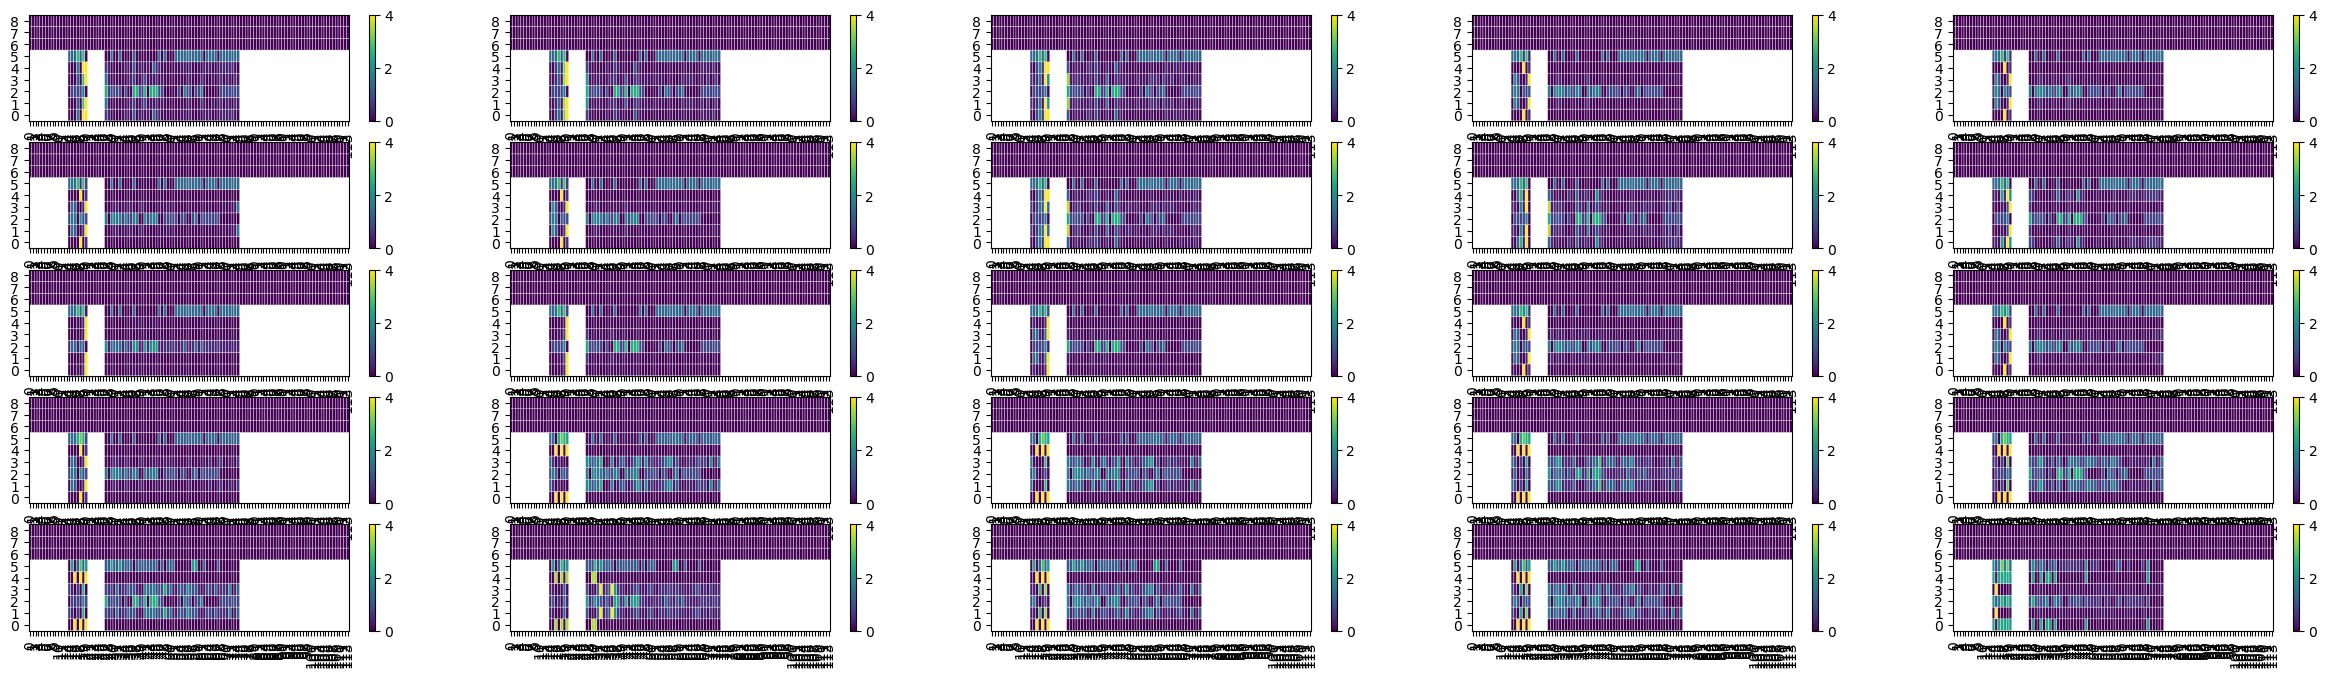

In [ ]:
cam_stacks.shape

cam_centers=np.nanmedian(cam_stacks,axis=0)
cam_stds = np.nanstd(cam_stacks,axis=0)

norm_cam_stack = np.divide(cam_stacks-cam_centers,cam_stds,
                           out=np.zeros_like(cam_stacks),
                           where=cam_stds!=0)


fig,ax=plt.subplots(5,5,figsize=(30,8))
ax=ax.flatten()
(vmin,vmax) = [4*d for d in [-1,1]]
for ax_i,c_ind in zip(ax,range(norm_cam_stack.shape[1])):
    xy_cam = norm_cam_stack[:,c_ind,...]
    xy_cam = flatten_end(xy_cam)
    cbh=ax_i.pcolor(abs(xy_cam.T),edgecolors='w',vmin=0,vmax=vmax)
    ax_i.set_yticks(np.arange(9)+.5,range(9))
    ax_i.set_xticks(np.arange(114)+.5,range(114),rotation=90)
    plt.colorbar(cbh)


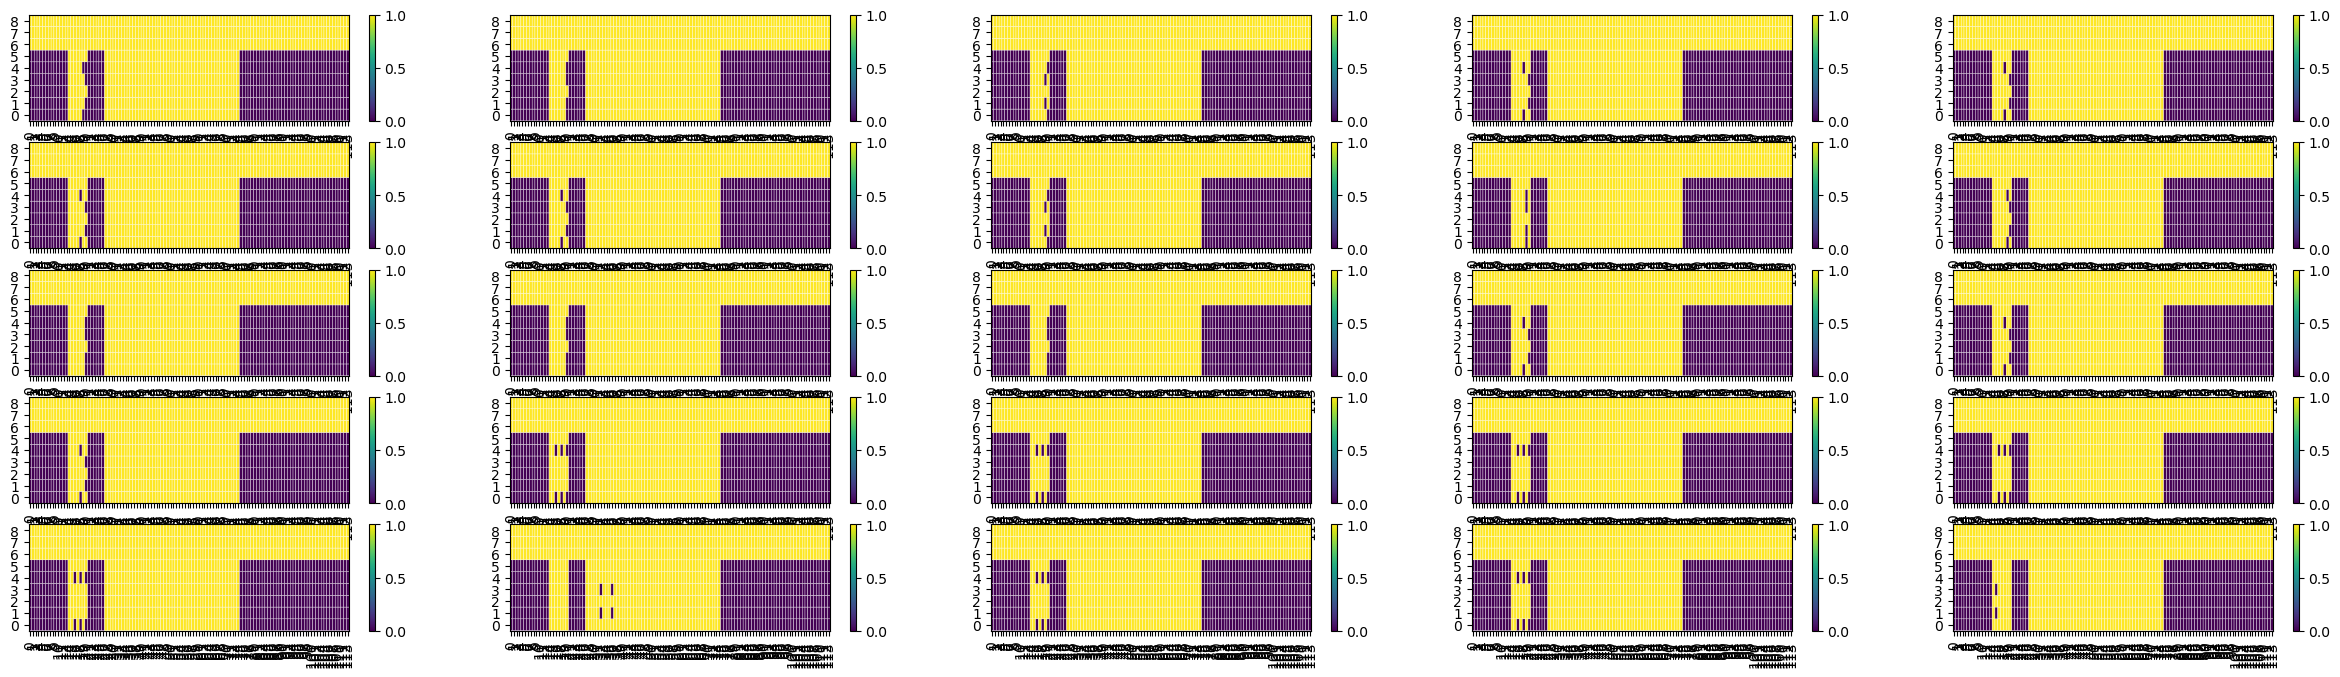

In [ ]:
cam_stack_isvalid =abs(norm_cam_stack)<4
fig,ax=plt.subplots(5,5,figsize=(30,8))
ax=ax.flatten()
(vmin,vmax) = [4*d for d in [-1,1]]
for ax_i,c_ind in zip(ax,range(cam_stack_isvalid.shape[1])):
    xy_cam_bool = cam_stack_isvalid[:,c_ind,...]
    xy_cam_bool = flatten_end(xy_cam_bool)
    vmax=1
    cbh=ax_i.pcolor(abs(xy_cam_bool.T),edgecolors='w',vmin=0,vmax=vmax)
    ax_i.set_yticks(np.arange(9)+.5,range(9))
    ax_i.set_xticks(np.arange(114)+.5,range(114),rotation=90)
    plt.colorbar(cbh)


In [ ]:

## AFF Transformation
"""
SSR = Scale Skew Rotation
X,Y = Translation
[[SSR,   SSR,    X],
 [SSR,   SSR,    Y],
 [0,     0,      1],]
"""

'\nSSR = Scale Skew Rotation\nX,Y = Translation\n[[SSR,   SSR,    X],\n [SSR,   SSR,    Y],\n [0,     0,      1],]\n'

In [ ]:


cam_stacks[np.logical_not(cam_stack_isvalid)]=np.nan
import sklearn as skl
cam_stacks_hat = cam_stacks.copy()
for ax_i,c_ind in zip(ax.flat,range(cam_stacks.shape[1])):
    xy_cam = cam_stacks[:,c_ind,...]
    model_Xs = np.arange(xy_cam.shape[0]).reshape(-1, 1)
    model_Ys = flatten_end(xy_cam)
    model_Ys_hat = model_Ys.copy()
    for i in range(model_Ys.shape[1]):
        Yi = model_Ys[:,i]
        good_val = np.logical_not(np.isnan(Yi))
        model = skl.linear_model.LinearRegression()
        model.fit(model_Xs[good_val],Yi[good_val])
        Yi_hat = model.predict(model_Xs)
        model_Ys_hat[:,i] = Yi_hat
    cam_stacks_hat[:,c_ind,...] = model_Ys_hat.reshape(xy_cam.shape)


# fig,ax=plt.subplots(5,5,figsize=(30,8))
# norm_cam_stacks_hat = np.divide(cam_stacks_hat-cam_centers,cam_stds,
#                                 out=np.zeros_like(cam_stacks),
#                                 where=cam_stds!=0)
# for ax_i,c_ind in zip(ax.flat,range(norm_cam_stacks_hat.shape[1])):
#     norm_model_Ys_hat = flatten_end(norm_cam_stacks_hat[:,c_ind,...])
#     cbh=ax_i.pcolor(abs(norm_model_Ys_hat.T),edgecolors='w')
#     ax_i.set_yticks(np.arange(9)+.5,range(9))
#     ax_i.set_xticks(np.arange(114)+.5,range(114),rotation=90)
#     plt.colorbar(cbh)




AttributeError: module 'sklearn' has no attribute 'linear_model'

In [ ]:
""" Stitcher Modules """
def feature_detect(aff_stitcher,my_images,results):
    features = aff_stitcher.find_features(my_images)
    results['features']=features
    num_feats = [len(f.keypoints) for f in results['features']]
    fewest_points = np.min(num_feats)
    return results


def match_feats(aff_stitcher,results):
    results['matches'] = aff_stitcher.match_features(results['features'])
    # conf_mat = aff_stitcher.matcher.get_confidence_matrix(matches)
    # conf_mat[conf_mat==0]=np.nan
    # indicies = aff_stitcher.subsetter.get_indices_to_keep(features,matches)
    # dot_notation = aff_stitcher.subsetter.get_matches_graph([str(i) for i in range(25)], matches)
    return results


def solve_for_camera(aff_stitcher,results):
    cameras = aff_stitcher.camera_estimator.estimate(results['features'], results['matches'])
    cameras = aff_stitcher.camera_adjuster.adjust(results['features'], results['matches'], cameras)
    cameras = aff_stitcher.wave_corrector.correct(cameras)
    aff_stitcher.warper.set_scale(cameras)
    results['cameras']=cameras
    return results

def apply_camera_transform(aff_stitcher,results):
    final_sizes = images.get_scaled_img_sizes(Images.Resolution.FINAL)
    camera_aspect = images.get_ratio(Images.Resolution.FINAL, Images.Resolution.FINAL)
    warped_final_imgs = list(aff_stitcher.warper.warp_images(final_imgs, cameras, camera_aspect))
    warped_final_masks = list(aff_stitcher.warper.create_and_warp_masks(final_sizes, cameras, camera_aspect))
    final_corners, final_sizes = aff_stitcher.warper.warp_rois(final_sizes, cameras, camera_aspect)

    results['camera_aspect']=camera_aspect
    results['warped_final_imgs']=warped_final_imgs
    results['warped_final_masks']=warped_final_masks
    results['final_corners']=final_corners
    results['final_sizes']=final_sizes
    return results

def cropping(aff_stitcher,results):
    """ Bleh Cropping Bad """
    results['cropped_final_imgs'] = results['warped_final_imgs']
    results['cropped_final_masks'] = results['warped_final_masks']
    return results


def stitch_scaled_images(aff_stitcher,reults):
    'Blend the Transformed Images'

    cropped_final_imgs = results['cropped_final_imgs']
    cropped_final_masks = results['cropped_final_masks']
    camera_aspect = results['camera_aspect']
    final_corners = results['final_corners']
    final_sizes = results['final_sizes']=


    """ Seams """
    seam_finder = aff_stitcher.seam_finder
    seam_masks = seam_finder.find(cropped_final_imgs, final_corners, cropped_final_masks)
    seam_masks_plots = [seam_finder.draw_seam_mask(img, seam_mask) for
        (img, seam_mask) in zip(cropped_final_imgs, seam_masks)]


    """ Exposure Comp """
    compensator = aff_stitcher.compensator
    compensator.feed(final_corners, cropped_final_imgs, cropped_final_masks)
    compensated_imgs = [compensator.apply(idx, corner, img, mask)
                        for idx, (img, mask, corner)
                        in enumerate(zip(cropped_final_imgs,
                                         cropped_final_masks,
                                         final_corners))]

    """ Blend """
    blender = aff_stitcher.blender
    blender.prepare(final_corners, final_sizes)
    for img, mask, corner in zip(compensated_imgs, seam_masks, final_corners):
        blender.feed(img, mask, corner)
    stitched, _ = blender.blend()
    results['stitched_image']=stitched
    return results



SyntaxError: invalid syntax (24603428.py, line 55)

In [ ]:
"""
Use Interpolated Cameras (affine matricies) to stitch full stack
"""
